In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.0 MB/s eta 0:00:00


In [2]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np
from transformers import BertConfig
from matplotlib import pyplot as plt
import pickle
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import math
from sklearn.metrics import classification_report
import torch.nn.functional as F
import torch
import torch.nn as nn
from transformers import BertModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [5]:
from os import getcwd, chdir

fpath = '/content/drive/MyDrive/MTech AI NUS/PM NLP/Dataset'
chdir(fpath)
getcwd()

'/content/drive/MyDrive/MTech AI NUS/PM NLP/Dataset'

In [196]:
data_df = pd.read_csv("vector2.csv")
data_df.head(2)

,place,reviewer,reviewer_location,reviewer_contributions,review_rating,review_type,review_date,review_title,review_text,language,...,lemmatized_clean_review_text,vector,is_train,fold,review_rating1,Predict_1,Predict_2,Predict_3,Predict_4,Predict_5
0,Bike Around Tour,mrflax,"Atlanta, GA",5.0,4.0,Friends,"May 3, 2019",Awesome Tour and Guide!,This is a worthwhile must-do tour in Singapore...,en,...,worthwhile mustdo tour singapore guide jeff fr...,[-1.73427186e-01 4.57350723e-01 9.22474668e-...,train,2.0,3.0,0.000095,0.000477,0.002118,0.057241,0.940069
1,Singapore_Botanic_Gardens,Jopin55,"Paris, France",130.0,5.0,Couples,"February 9, 2016",Lovely,I love that place. Besides the fact that it re...,en,...,love place fact remind live singapore used run...,[ 0.18570898 -0.16400906 -0.31473174 0.231178...,train,1.0,4.0,0.002216,0.027473,0.045503,0.228833,0.695975


In [197]:
data_df['place'].nunique()

39

In [118]:
data_df['review_rating'] = data_df['review_rating'].astype(int)

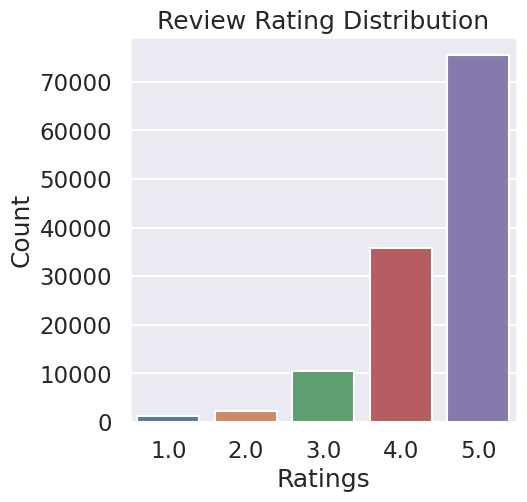

In [133]:
plt.figure(figsize=(5,5))
sns.set(style = 'darkgrid')
sns.set_context("talk")
sns.countplot(data = data_df, x = 'review_rating')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Review Rating Distribution')
plt.show()

In [8]:
def target(x):
    return x-1

In [9]:
data_df['review_rating'] = data_df['review_rating'].apply(target)
data_df.head(2)

,place,reviewer,reviewer_location,reviewer_contributions,review_rating,review_type,review_date,review_title,review_text,language,...,lemmatized_clean_review_text,vector,is_train,fold,review_rating1,Predict_1,Predict_2,Predict_3,Predict_4,Predict_5
0,Bike Around Tour,mrflax,"Atlanta, GA",5.0,3,Friends,"May 3, 2019",Awesome Tour and Guide!,This is a worthwhile must-do tour in Singapore...,en,...,worthwhile mustdo tour singapore guide jeff fr...,[-1.73427186e-01 4.57350723e-01 9.22474668e-...,train,2.0,3.0,0.000095,0.000477,0.002118,0.057241,0.940069
1,Singapore_Botanic_Gardens,Jopin55,"Paris, France",130.0,4,Couples,"February 9, 2016",Lovely,I love that place. Besides the fact that it re...,en,...,love place fact remind live singapore used run...,[ 0.18570898 -0.16400906 -0.31473174 0.231178...,train,1.0,4.0,0.002216,0.027473,0.045503,0.228833,0.695975


In [ ]:
df_train = data_df[data_df['is_train'] == 'train'][['lemmatized_clean_review_text','review_rating']]
print('Train : ', df_train.shape)
df_cv = data_df[data_df['is_train'] == 'test'][['lemmatized_clean_review_text','review_rating']]
print('CV : ', df_cv.shape)
df_test = data_df[data_df['is_train'] == 'unseen'][['lemmatized_clean_review_text','review_rating']]
print('Test : ', df_test.shape)

Train :  (78282, 2)
CV :  (19571, 2)
Test :  (97853, 2)


In [ ]:
print(df_train['review_rating'].value_counts())
print(df_cv['review_rating'].value_counts())
print(df_test['review_rating'].value_counts())

4    47292
3    22313
2     6519
1     1358
0      800
Name: review_rating, dtype: int64
4    11702
3     5665
2     1655
1      356
0      193
Name: review_rating, dtype: int64
4    58863
3    27965
2     8222
1     1782
0     1021
Name: review_rating, dtype: int64


In [ ]:
# data_texts = list(data_df['lemmatized_clean_review_text'])

# data_labels = list(data_df['review_rating'])

In [ ]:
# from sklearn.model_selection import train_test_split
# train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )
# train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )

In [ ]:
train_texts = list(df_train['lemmatized_clean_review_text'])
train_labels = list(df_train['review_rating'])

val_texts = list(df_cv['lemmatized_clean_review_text'])
val_labels = list(df_cv['review_rating'])

test_texts = list(df_test['lemmatized_clean_review_text'])
test_labels = list(df_test['review_rating'])

In [ ]:
import torch
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
#tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=512, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_input_ids, train_att_masks = encode(train_texts)
valid_input_ids, valid_att_masks = encode(val_texts)

In [ ]:
train_y = torch.LongTensor(train_labels)
valid_y = torch.LongTensor(val_labels)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 16
test_input_ids, test_att_masks = encode(test_texts)
test_y = torch.LongTensor(test_labels)
test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
from transformers import BertForSequenceClassification
PRETRAINED_LM = "bert-base-uncased"
N_labels = len(data_df.review_rating.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model = model.cuda()

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )


In [ ]:
N_labels = len(data_df.review_rating.unique())
n_samples = df_train.shape[0]
n_classes = N_labels

weights_dict = dict()
for i in list(range(0,5)):
    weights_dict[i] = round((n_samples / (n_classes * df_train['review_rating'].value_counts()[i])),3)

print(weights_dict)

weights_dict = {k : v / total for total in (sum(weights_dict.values(), 0.0),) for k, v in weights_dict.items()}

print(weights_dict)

{0: 19.57, 1: 11.529, 2: 2.402, 3: 0.702, 4: 0.331}
{0: 0.566687901777958, 1: 0.33384490646898707, 2: 0.06955464180228181, 3: 0.02032779289975097, 4: 0.009584757051022182}


In [ ]:
with open('focal_loss_class_weights.pkl', 'wb+') as fp:
    pickle.dump(weights_dict, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [ ]:
with open('focal_loss_class_weights.pkl', 'rb') as fp:
    weights_dict = pickle.load(fp)
    print('Class Weight dictionary')
    print(weights_dict)

Class Weight dictionary
{0: 0.566687901777958, 1: 0.33384490646898707, 2: 0.06955464180228181, 3: 0.02032779289975097, 4: 0.009584757051022182}


In [ ]:
#https://github.com/AdeelH/pytorch-multi-class-focal-loss

focal_loss = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='focal_loss',
	alpha=[weights_dict[0], weights_dict[1], weights_dict[2],weights_dict[3],weights_dict[4] ],
	gamma=2,
	reduction='mean',
	device='cuda',
	dtype=torch.float32,
	force_reload=False
)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/adeelh/pytorch-multi-class-focal-loss/zipball/master" to /root/.cache/torch/hub/master.zip


In [ ]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        #print("outputs size ==> ",len(output.logits))
        #print("targets[:, 0] size ==> ",len(labels))
        #loss = output.loss
        loss = focal_loss(output.logits, labels)
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            #loss = output.loss
            loss = focal_loss(output.logits, labels)
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_texts) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(val_texts) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/4893 [00:00<?, ?it/s]

Validation:   0%|          | 0/1224 [00:00<?, ?it/s]

4893/4893 train loss: 0.022885712969261333 
1224/1224 val loss: 0.01928454145197178 
Epoch:  2


Training:   0%|          | 0/4893 [00:00<?, ?it/s]

Validation:   0%|          | 0/1224 [00:00<?, ?it/s]

4893/4893 train loss: 0.01853403523628102 
1224/1224 val loss: 0.01932983477565679 
Epoch:  3


Training:   0%|          | 0/4893 [00:00<?, ?it/s]

Validation:   0%|          | 0/1224 [00:00<?, ?it/s]

4893/4893 train loss: 0.01722650970358972 
1224/1224 val loss: 0.01990836081734183 


In [ ]:
save_directory = "/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v4_new" 

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v4/tokenizer_config.json',
 '/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v4/special_tokens_map.json',
 '/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v4/vocab.txt',
 '/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v4/added_tokens.json')

In [ ]:
# save_directory = "/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v4_new" 
# model = model.save_pretrained(save_directory)

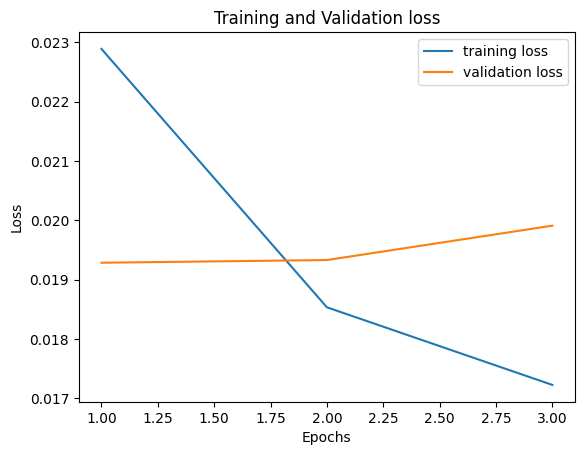

In [ ]:
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, df_cv['review_rating'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.37      0.40      0.38       177
           1       0.43      0.19      0.26       805
           2       0.45      0.24      0.32      3033
           3       0.42      0.41      0.42      5726
           4       0.66      0.78      0.71      9830

    accuracy                           0.56     19571
   macro avg       0.46      0.41      0.42     19571
weighted avg       0.54      0.56      0.54     19571



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()

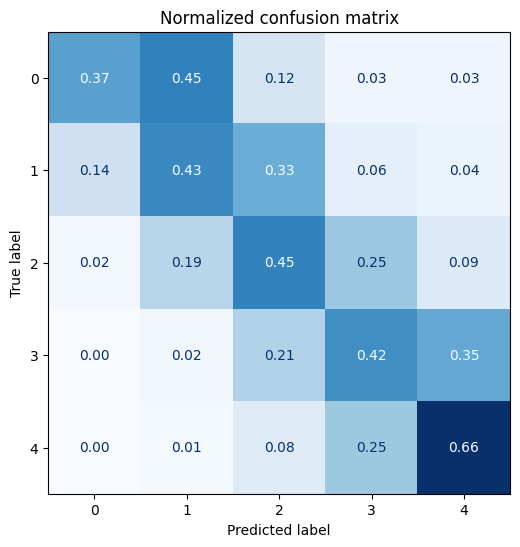

In [ ]:
plot_confusion_matrix(valid_pred, df_cv['review_rating'].to_numpy())

##### INFERENCE PART

In [ ]:
with open('focal_loss_class_weights.pkl', 'rb') as fp:
    weights_dict = pickle.load(fp)
    print('Class Weight dictionary')
    print(weights_dict)

Class Weight dictionary
{0: 0.566687901777958, 1: 0.33384490646898707, 2: 0.06955464180228181, 3: 0.02032779289975097, 4: 0.009584757051022182}


In [ ]:
#https://github.com/AdeelH/pytorch-multi-class-focal-loss

focal_loss = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='focal_loss',
	alpha=[weights_dict[0], weights_dict[1], weights_dict[2],weights_dict[3],weights_dict[4] ],
	gamma=2,
	reduction='mean',
	device='cuda',
	dtype=torch.float32,
	force_reload=False
)

Using cache found in /root/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


In [ ]:
loaded_tokenizer_pt = BertTokenizer.from_pretrained("/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v4/")

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = loaded_tokenizer_pt.batch_encode_plus(docs, add_special_tokens=True, max_length=512, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 16
test_input_ids, test_att_masks = encode(test_texts)
test_y = torch.LongTensor(test_labels)
test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
config = BertConfig.from_json_file("/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v4/config.json")
loaded_model_pt = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v4/pytorch_model.bin', 
                                                                config =config )

In [ ]:
loaded_model_pt.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
loaded_model_pt.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = loaded_model_pt(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = focal_loss(output.logits, labels)
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
print('Test Classifiation report')
print(classification_report(test_pred, df_test['review_rating'].to_numpy()))

Test Classifiation report
              precision    recall  f1-score   support

           0       0.38      0.42      0.40       904
           1       0.45      0.20      0.28      3900
           2       0.46      0.25      0.32     15085
           3       0.42      0.41      0.42     28709
           4       0.66      0.79      0.72     49255

    accuracy                           0.57     97853
   macro avg       0.47      0.42      0.43     97853
weighted avg       0.55      0.57      0.55     97853



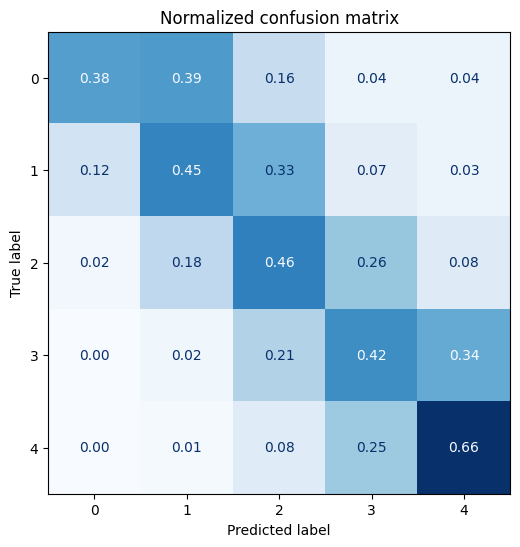

In [ ]:
plot_confusion_matrix(test_pred,df_test['review_rating'].to_numpy())

##### INFERENCE ON SINGLE REVIEW

In [ ]:
test_text = test_texts[10000]
print(test_text)
groundTruth = test_labels[10000]
print(groundTruth)

allow plenty time explore dome locate garden bay well do keep eye hidden treasure plant plant healthy beautiful orchid maiden hair fern water feature soon enter show great experience hot humid outside temperature perfect rate see day singapore easy access mrt shuttle service good value especially walk lot senior discount apply local resident
4


In [ ]:
predict_input_pt = loaded_tokenizer_pt.encode(test_text, add_special_tokens=True, max_length=512, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt').to('cuda')
                            
output_pt = loaded_model_pt(predict_input_pt)[0]

predictions_value_pt = torch.argmax(output_pt[0], dim=-1).item()
print(predictions_value_pt)

4


In [ ]:
output = loaded_model_pt(input_ids = predict_input_pt)
logits = output.logits
probabilities = max(F.softmax(logits, dim=-1)[0])
print(probabilities)

tensor(0.2760, device='cuda:0', grad_fn=<UnbindBackward0>)


In [ ]:
predict_input_pt

tensor([[  101,  2036,  3942,  8432,  5264,  3325,  3052, 17904,  6090,  6525,
          7712,  3193,  2103,  2036,  4021,  2015,  2312,  8089,  5217, 23821,
          5452,  2022,  6229,  7610,  3679, 14406, 22507,  3342,  4638,  4633,
          5309,  7281,  5452,  8505,  7407,  3808,  3653,  3540, 13700,  3811,
          6749,  2155,  2775,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

FINE TUNED BERT - APPROACH 2

Add 1 extra layer

In [17]:
import torch.nn as nn
def classifer(D_in, H, D_out):
    return nn.Sequential(
                nn.Linear(D_in, H),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(H, H),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(H, H),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(H, D_out),
            )

In [18]:
from transformers import BertForSequenceClassification
# Create the BertClassfier class
class BertClassifier(nn.Module):
    
    def __init__(self,classifer, freeze_bert=False):
        
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 200, 5

        # Instantiate BERT model     

        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=5,output_attentions=False,output_hidden_states=True)
        #self.bert = loaded_tokenizer_pt
        #self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = classifer(D_in, H, D_out)

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,attention_mask=attention_mask,output_hidden_states=True)
        #print("outputs size ==> ",outputs)
        hidden_states = outputs.hidden_states[0]
        #print(hidden_states)
        
        # Extract the last hidden state of the token `[CLS]` for classification task

        input_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
        sum_embeddings = torch.sum(hidden_states * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask 
        
        # Feed input to classifier to compute logits
        logits = self.classifier(mean_embeddings)
        #print(len(logits))
        return logits

In [21]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(classifer,epochs=4):

    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(classifer,freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=3e-5,    # Default learning rate - 5e-5, 3e-5 (56% acc), 2e-5(53% acc), 1e-5
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps 
    total_steps =  len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
#loss_fn = nn.CrossEntropyLoss()
import random
import time

def set_seed(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_acc = []
    epoch_val_acc = []
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, total_accuracy, batch_accuracy, batch_loss, batch_counts = 0, 0, 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = focal_loss(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Get the predictions
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the accuracy 
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            batch_accuracy += accuracy
            total_accuracy += accuracy

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {batch_accuracy / batch_counts:^12.6f} |{'-':^12} | {'-':^12} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts ,batch_accuracy = 0, 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = total_accuracy / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            # Print training results
            print(f"{epoch_i + 1:^7} | {step:^7} | {avg_train_loss:^12.6f} | {avg_train_accuracy:^12.6f} | {val_loss:^12.6f} | {val_accuracy:^12.6f}| {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(val_loss)
        epoch_train_acc.append(avg_train_accuracy)
        epoch_val_acc.append(val_accuracy)
    
    print("Training complete!")
    return epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc


def evaluate(model, val_dataloader):
    
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    valid_pred = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = focal_loss(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, train_loss, val_loss):
    # Create a figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Training history ', fontsize=16)
    fig.subplots_adjust(top=0.8)

    # Plot training & validation accuracy values
    ax1.plot(train_acc)
    ax1.plot(val_acc)
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(train_loss)
    ax2.plot(val_loss)
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    # Show the figure
    plt.show()

56% acc model 7

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(classifer,epochs=4)
epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc = train(bert_classifier, train_dataloader, valid_dataloader, epochs=4, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Start training...

 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.023526   |  28.571429   |     -       |      -       |   5.62   
   1    |   40    |   0.023011   |  25.312500   |     -       |      -       |   2.51   
   1    |   60    |   0.030999   |  25.937500   |     -       |      -       |   2.51   
   1    |   80    |   0.030815   |  28.125000   |     -       |      -       |   2.51   
   1    |   100   |   0.030568   |  30.000000   |     -       |      -       |   2.51   
   1    |   120   |   0.027026   |  30.937500   |     -       |      -       |   2.51   
   1    |   140   |   0.022313   |  30.000000   |     -       |      -       |   2.51   
   1    |   160   |   0.036238   |  31.875000   |     -       |      -       |   2.51   
   1    |   180   |   0.029592   |  28.125000   |     -       |      -       |   2.51   
   1    |   200   |   0.

In [ ]:
save_directory = "/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v7" 

torch.save(bert_classifier, save_directory)

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v7_tok/")

('/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v8_tok/tokenizer_config.json',
 '/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v8_tok/special_tokens_map.json',
 '/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v8_tok/vocab.txt',
 '/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v8_tok/added_tokens.json')

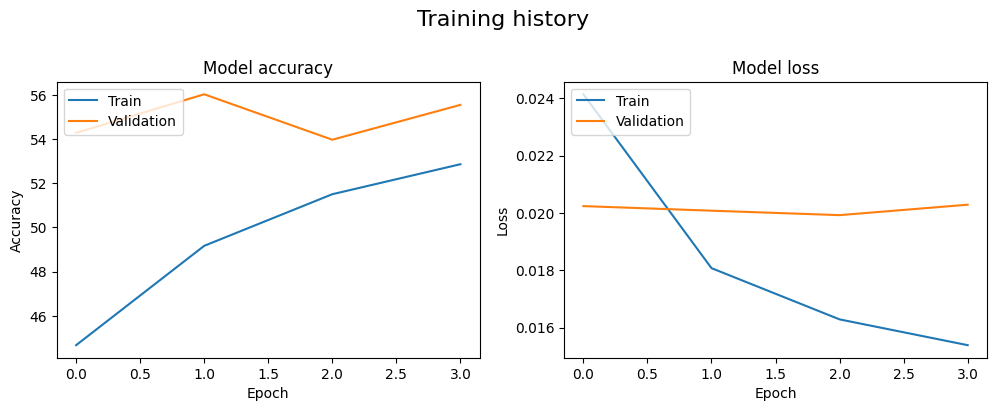

In [ ]:
plot_training_history(epoch_train_acc, epoch_val_acc, epoch_train_loss, epoch_val_loss)

INFERENCE - TEST DATA

In [14]:
save_directory = "/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v7" 

In [12]:
loaded_tokenizer_pt = BertTokenizer.from_pretrained("/content/drive/MyDrive/MTech AI NUS/PM NLP/saved_models_v7_tok/")

In [22]:
bert_classifier, optimizer, scheduler = initialize_model(classifer,epochs=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
model = torch.load(save_directory)

In [28]:
def test(model, dataloader):
  model.eval()
  test_pred = []
  test_loss= 0
  all_logits = []
  with torch.no_grad():
      for step_num, batch_data in tqdm(enumerate(dataloader)):
          input_ids, att_mask, labels = [data.to(device) for data in batch_data]
          logits = model(input_ids = input_ids, attention_mask=att_mask)

          loss = focal_loss(logits, labels)
          test_loss += loss.item()
   
          test_pred.append(np.argmax(logits.cpu().detach().numpy(),axis=-1))
          all_logits.append(logits)

      # Concatenate logits from each batch
      all_logits = torch.cat(all_logits, dim=0)

      # Apply softmax to calculate probabilities
      probs = F.softmax(all_logits, dim=1).cpu().numpy()
  test_pred = np.concatenate(test_pred)
  return test_pred,probs

In [ ]:
valid_pred = test(model,valid_dataloader)

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, df_cv['review_rating'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.47      0.29      0.36       309
           1       0.36      0.15      0.21       849
           2       0.39      0.23      0.29      2876
           3       0.37      0.40      0.39      5243
           4       0.67      0.77      0.72     10294

    accuracy                           0.56     19571
   macro avg       0.45      0.37      0.39     19571
weighted avg       0.54      0.56      0.54     19571



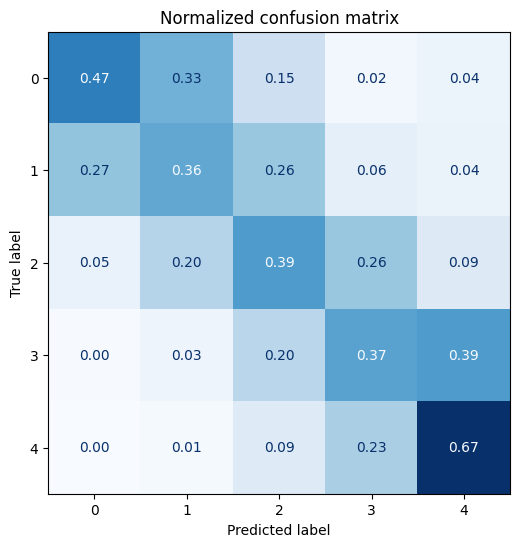

In [ ]:
plot_confusion_matrix(valid_pred, df_cv['review_rating'].to_numpy())

In [ ]:
test_pred = test(model,test_dataloader)

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(test_pred, df_test['review_rating'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.51      0.35      0.41      1510
           1       0.40      0.17      0.24      4289
           2       0.40      0.23      0.29     14449
           3       0.38      0.40      0.39     26670
           4       0.67      0.78      0.72     50935

    accuracy                           0.56     97853
   macro avg       0.47      0.38      0.41     97853
weighted avg       0.54      0.56      0.54     97853



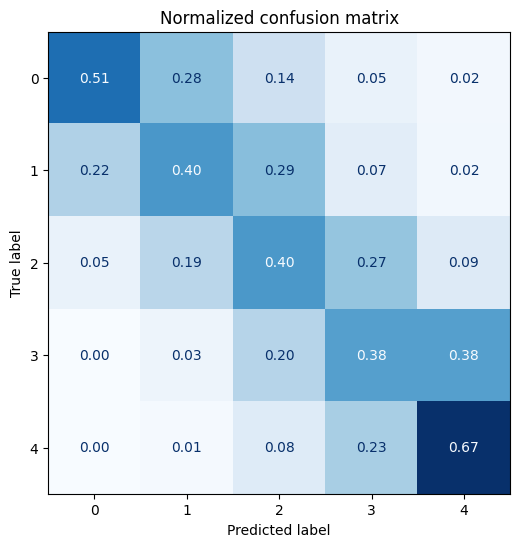

In [ ]:
plot_confusion_matrix(test_pred, df_test['review_rating'].to_numpy())

INFERENCE ON 20 PLACES:

In [11]:
inference_texts = list(data_df['lemmatized_clean_review_text'])
inference_labels = list(data_df['review_rating'])

In [24]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = loaded_tokenizer_pt.batch_encode_plus(docs, add_special_tokens=True, max_length=512, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 16
inference_input_ids, inference_att_masks = encode(inference_texts)
inference_y = torch.LongTensor(inference_labels)
inference_dataset = TensorDataset(inference_input_ids, inference_att_masks, inference_y)
inference_sampler = SequentialSampler(inference_dataset)
inference_dataloader = DataLoader(inference_dataset, sampler=inference_sampler, batch_size=BATCH_SIZE)

In [30]:
inference_pred, inference_probs = test(model,inference_dataloader)

0it [00:00, ?it/s]

In [185]:
data_df[['Bert_Probs1','Bert_Probs2','Bert_Probs3','Bert_Probs4','Bert_Probs5']] = inference_probs

In [136]:
data_df.head(2)

,place,reviewer,reviewer_location,reviewer_contributions,review_rating,review_type,review_date,review_title,review_text,language,...,Predict_1,Predict_2,Predict_3,Predict_4,Predict_5,Bert_Probs1,Bert_Probs2,Bert_Probs3,Bert_Probs4,Bert_Probs5
0,Bike Around Tour,mrflax,"Atlanta, GA",5.0,4.0,Friends,"May 3, 2019",Awesome Tour and Guide!,This is a worthwhile must-do tour in Singapore...,en,...,0.000095,0.000477,0.002118,0.057241,0.940069,0.001583,0.01168,0.105606,0.363156,0.517975
1,Singapore_Botanic_Gardens,Jopin55,"Paris, France",130.0,5.0,Couples,"February 9, 2016",Lovely,I love that place. Besides the fact that it re...,en,...,0.002216,0.027473,0.045503,0.228833,0.695975,0.005395,0.03082,0.186847,0.380644,0.396294


In [62]:
def get_topic_words(df):
  unique_words = []
  for w in df:
      unique_words.append(w)
  #print(unique_words)
  return unique_words

In [186]:
data_df['ML Probs'] = data_df.apply(lambda x: get_topic_words(x[['Predict_1','Predict_2',	'Predict_3',	'Predict_4',	'Predict_5']] ), axis=1)
data_df.head()

,place,reviewer,reviewer_location,reviewer_contributions,review_rating,review_type,review_date,review_title,review_text,language,...,Predict_2,Predict_3,Predict_4,Predict_5,Bert_Probs1,Bert_Probs2,Bert_Probs3,Bert_Probs4,Bert_Probs5,ML Probs
0,Bike Around Tour,mrflax,"Atlanta, GA",5.0,4.0,Friends,"May 3, 2019",Awesome Tour and Guide!,This is a worthwhile must-do tour in Singapore...,en,...,0.000477,0.002118,0.057241,0.940069,0.001583,0.011680,0.105606,0.363156,0.517975,"[9.474364e-05, 0.00047701926, 0.002117896, 0.0..."
1,Singapore_Botanic_Gardens,Jopin55,"Paris, France",130.0,5.0,Couples,"February 9, 2016",Lovely,I love that place. Besides the fact that it re...,en,...,0.027473,0.045503,0.228833,0.695975,0.005395,0.030820,0.186847,0.380644,0.396294,"[0.0022158443, 0.02747276, 0.045502722, 0.2288..."
2,Singapore Flyer,Robyn A,"Brisbane, Australia",629.0,5.0,NaN,"November 3, 2011",Great Views of the City ~ Great Experience,30 minute trip on the flyer was great. Very h...,en,...,0.001282,0.097904,0.400355,0.499950,0.001112,0.013277,0.155789,0.421961,0.407861,"[0.0005090932, 0.0012815729, 0.09790357, 0.400..."
3,Merlion_Park,sborzone,"Rosario, Argentina",337.0,5.0,Business,15-Apr-18,Great walk!,IdealPark to walk around after an exhausting d...,en,...,0.016929,0.130713,0.279770,0.571362,0.001799,0.014373,0.130849,0.384404,0.468575,"[0.0012264907, 0.016928636, 0.13071314, 0.2797..."
4,Bugis Street,768colins,"Perth, Australia",19.0,4.0,NaN,"May 10, 2017",Always a lot of fun to visit,Bugis St has been a major attraction for touri...,en,...,0.036740,0.320435,0.461071,0.180530,0.000873,0.011810,0.159513,0.433480,0.394324,"[0.0012230581, 0.036740273, 0.3204354, 0.46107..."


In [189]:
data_df['Bert Probs'] = data_df.apply(lambda x: get_topic_words(x[['Bert_Probs1','Bert_Probs2',	'Bert_Probs3',	'Bert_Probs4',	'Bert_Probs5']] ), axis=1)
data_df.head(2)

,place,reviewer,reviewer_location,reviewer_contributions,review_rating,review_type,review_date,review_title,review_text,language,...,Predict_3,Predict_4,Predict_5,Bert_Probs1,Bert_Probs2,Bert_Probs3,Bert_Probs4,Bert_Probs5,ML Probs,Bert Probs
0,Bike Around Tour,mrflax,"Atlanta, GA",5.0,4.0,Friends,"May 3, 2019",Awesome Tour and Guide!,This is a worthwhile must-do tour in Singapore...,en,...,0.002118,0.057241,0.940069,0.001583,0.01168,0.105606,0.363156,0.517975,"[9.474364e-05, 0.00047701926, 0.002117896, 0.0...","[0.001583313336595893, 0.011679829098284245, 0..."
1,Singapore_Botanic_Gardens,Jopin55,"Paris, France",130.0,5.0,Couples,"February 9, 2016",Lovely,I love that place. Besides the fact that it re...,en,...,0.045503,0.228833,0.695975,0.005395,0.03082,0.186847,0.380644,0.396294,"[0.0022158443, 0.02747276, 0.045502722, 0.2288...","[0.005395307671278715, 0.030820267274975777, 0..."


In [94]:
def ensemble_probs(df):
  probs = []
  for i in range(len(df[0])):
      x = df[0][i]
      y = df[1][i]
      avg = (x+y)/2
      probs.append(avg)
  return probs

In [190]:
data_df['Ensemble_Probs'] = data_df.apply(lambda x: ensemble_probs(x[['ML Probs','Bert Probs']]),axis = 1)

In [86]:
data_df.head(2)

,place,reviewer,reviewer_location,reviewer_contributions,review_rating,review_type,review_date,review_title,review_text,language,...,Predict_4,Predict_5,Bert_Probs1,Bert_Probs2,Bert_Probs3,Bert_Probs4,Bert_Probs5,ML Probs,Bert Probs,Ensemble_Probs
0,Bike Around Tour,mrflax,"Atlanta, GA",5.0,3,Friends,"May 3, 2019",Awesome Tour and Guide!,This is a worthwhile must-do tour in Singapore...,en,...,0.057241,0.940069,0.001583,0.01168,0.105606,0.363156,0.517975,"[9.474364e-05, 0.00047701926, 0.002117896, 0.0...","[0.001583313336595893, 0.011679829098284245, 0...","[0.0008390284882979465, 0.006078424179142122, ..."
1,Singapore_Botanic_Gardens,Jopin55,"Paris, France",130.0,4,Couples,"February 9, 2016",Lovely,I love that place. Besides the fact that it re...,en,...,0.228833,0.695975,0.005395,0.03082,0.186847,0.380644,0.396294,"[0.0022158443, 0.02747276, 0.045502722, 0.2288...","[0.005395307671278715, 0.030820267274975777, 0...","[0.0038055759856393577, 0.029146513637487888, ..."


In [112]:
def ensemble_ratings(df):
  rating = df.index(max(df))+1
  return rating

In [191]:
data_df['Ensemble_Ratings'] = data_df.apply(lambda x: ensemble_ratings(x['Ensemble_Probs']),axis = 1)

In [115]:
(data_df.value_counts(subset = ['place', 'Ensemble_Ratings'])).to_csv('Ensemble_Ratings.csv')

In [116]:
data_df.value_counts(subset = ['place', 'Ensemble_Ratings'])

place                              Ensemble_Ratings
Singapore_Botanic_Gardens          5                   8537
Singapore Zoo                      5                   7927
Gardens by the bay                 5                   6669
Singapore_Mass_Rapid_Transit_SMRT  5                   6509
cloud_forest                       5                   6217
                                                       ... 
National_Orchid_Garden             1                      6
The Helix Bridge                   1                      4
Waterfront Promenade               1                      3
MacRitchie Nature Trail            1                      2
                                   2                      2
Length: 192, dtype: int64

In [192]:
data_df.head(2)

,place,reviewer,reviewer_location,reviewer_contributions,review_rating,review_type,review_date,review_title,review_text,language,...,Predict_5,Bert_Probs1,Bert_Probs2,Bert_Probs3,Bert_Probs4,Bert_Probs5,ML Probs,Bert Probs,Ensemble_Probs,Ensemble_Ratings
0,Bike Around Tour,mrflax,"Atlanta, GA",5.0,4.0,Friends,"May 3, 2019",Awesome Tour and Guide!,This is a worthwhile must-do tour in Singapore...,en,...,0.940069,0.001583,0.01168,0.105606,0.363156,0.517975,"[9.474364e-05, 0.00047701926, 0.002117896, 0.0...","[0.001583313336595893, 0.011679829098284245, 0...","[0.0008390284882979465, 0.006078424179142122, ...",5
1,Singapore_Botanic_Gardens,Jopin55,"Paris, France",130.0,5.0,Couples,"February 9, 2016",Lovely,I love that place. Besides the fact that it re...,en,...,0.695975,0.005395,0.03082,0.186847,0.380644,0.396294,"[0.0022158443, 0.02747276, 0.045502722, 0.2288...","[0.005395307671278715, 0.030820267274975777, 0...","[0.0038055759856393577, 0.029146513637487888, ...",5


In [195]:
data_df['place'].nunique()

39

In [180]:
data_df1 = data_df[data_df['place'] == 'Raffles Hotel Arcade']
data_df1.to_csv('Ensemble_Ratings_Raffles Hotel Arcade.csv')

In [194]:
for i in data_df['place'].unique():
  data_df[data_df['place'] == str(i)].to_csv('Ensemble_Ratings_'+str(i)+'.csv')